In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
import time
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from datetime import datetime
from transformers import SwinModel, AutoImageProcessor
import warnings
warnings.filterwarnings('ignore')

In [2]:
import gc
import torch

# Only delete if the variable exists
if 'some_large_tensor' in locals():
    del some_large_tensor

gc.collect()
torch.cuda.empty_cache()

In [3]:
# Seting the display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

In [4]:
# Checking the GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla P100-PCIE-16GB


In [5]:
# Setting the random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# **Loading the Data**

In [6]:
train = pd.read_csv("/kaggle/input/final-augment-train-df-2/final_augmented_balanced_df_finall2.csv")
train.head()

,Unnamed: 0,image,Melanoma,Melanocytic_nevus,Basal_cell_carcinoma,Actinic_keratosis,Benign_keratosis,Dermatofibroma,Vascular_lesion,Squamous_cell_carcinoma,image_path,site_anterior torso,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_posterior torso,site_upper extremity,sex_female,sex_male,age_1-10,age_11-20,age_21-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-90,disease_label
0,0,ISIC_0033358,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0033358.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1,0,Actinic_keratosis
1,1,ISIC_0064621,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/kaggle/working/augmented_images_finall2/Vascular_lesion/Vascular_lesion_rotation_-30/Vascular_lesion_3410_rotation_-30.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0,0,Vascular_lesion
2,2,ISIC_0070338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/kaggle/working/augmented_images_finall2/Squamous_cell_carcinoma/Squamous_cell_carcinoma_rotation_20rotation_-15/Squamous_cell_carcinoma_224_rotation_20rotation_-15.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,Squamous_cell_carcinoma
3,3,ISIC_0028864,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028864.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,1,0,0,0,Melanocytic_nevus
4,4,ISIC_0066097,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/kaggle/working/augmented_images_finall2/Vascular_lesion/Vascular_lesion_rotation_30/Vascular_lesion_3575_rotation_30.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,Vascular_lesion


In [7]:
# Loading and preparing the data
train['image_path'] = train['image_path'].str.replace(
    '/kaggle/working/augmented_images_finall2/', '/kaggle/input/augmented-final-2/', regex=False
)
train = train.drop(columns=["Unnamed: 0", "image"])

In [8]:
test_df = pd.read_csv("/kaggle/input/test-df-final-2/test_df_finall.csv")
test_df = test_df.drop(columns=["image"])

print(f"Training data shape: {train.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (36860, 27)
Testing data shape: (2293, 28)


In [9]:
train.head()

,Melanoma,Melanocytic_nevus,Basal_cell_carcinoma,Actinic_keratosis,Benign_keratosis,Dermatofibroma,Vascular_lesion,Squamous_cell_carcinoma,image_path,site_anterior torso,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_posterior torso,site_upper extremity,sex_female,sex_male,age_1-10,age_11-20,age_21-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-90,disease_label
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0033358.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1,0,Actinic_keratosis
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/kaggle/input/augmented-final-2/Vascular_lesion/Vascular_lesion_rotation_-30/Vascular_lesion_3410_rotation_-30.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0,0,Vascular_lesion
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,/kaggle/input/augmented-final-2/Squamous_cell_carcinoma/Squamous_cell_carcinoma_rotation_20rotation_-15/Squamous_cell_carcinoma_224_rotation_20rotation_-15.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,Squamous_cell_carcinoma
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028864.jpg,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0,0,0,0,1,0,0,0,Melanocytic_nevus
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,/kaggle/input/augmented-final-2/Vascular_lesion/Vascular_lesion_rotation_30/Vascular_lesion_3575_rotation_30.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,Vascular_lesion


In [10]:
test_df.head()

,Unnamed: 0,Melanoma,Melanocytic_nevus,Basal_cell_carcinoma,Actinic_keratosis,Benign_keratosis,Dermatofibroma,Vascular_lesion,Squamous_cell_carcinoma,image_path,site_anterior torso,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_posterior torso,site_upper extremity,sex_female,sex_male,age_1-10,age_11-20,age_21-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-90,disease_label
0,20321,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0069911.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0,0,Melanocytic_nevus
1,14612,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0060639.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,Benign_keratosis
2,17067,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0064685.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1,0,Basal_cell_carcinoma
3,12065,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0056533.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,Melanocytic_nevus
4,14656,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0060702.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,Basal_cell_carcinoma


In [11]:
test_df = test_df.drop(columns=["Unnamed: 0"])
test_df.head()

,Melanoma,Melanocytic_nevus,Basal_cell_carcinoma,Actinic_keratosis,Benign_keratosis,Dermatofibroma,Vascular_lesion,Squamous_cell_carcinoma,image_path,site_anterior torso,site_head/neck,site_lower extremity,site_oral/genital,site_palms/soles,site_posterior torso,site_upper extremity,sex_female,sex_male,age_1-10,age_11-20,age_21-30,age_31-40,age_41-50,age_51-60,age_61-70,age_71-90,disease_label
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0069911.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0,0,Melanocytic_nevus
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0060639.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,Benign_keratosis
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0064685.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,1,0,Basal_cell_carcinoma
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0056533.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1,0,Melanocytic_nevus
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/kaggle/input/isic19/ISIC 2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0060702.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,1,Basal_cell_carcinoma


In [13]:
# Define classes and create label mapping
unique_classes = sorted(train['disease_label'].unique())
NUM_CLASSES = len(unique_classes)
print(f"Class names: {unique_classes}")
print(f"Number of classes: {NUM_CLASSES}")

Class names: ['Actinic_keratosis', 'Basal_cell_carcinoma', 'Benign_keratosis', 'Dermatofibroma', 'Melanocytic_nevus', 'Melanoma', 'Squamous_cell_carcinoma', 'Vascular_lesion']
Number of classes: 8


In [14]:
label_to_id = {label: idx for idx, label in enumerate(unique_classes)}
id_to_label = {idx: label for idx, label in enumerate(unique_classes)}

# Train/validation split 80%/20% 
# (This is not train/ test split, because this split was done during the cleaning already)

In [15]:
# Split data with stratification
train_df, valid_df = train_test_split(train,
                                    test_size=0.2,
                                    stratify=train['disease_label'],
                                    random_state=42)

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 29488
Validation set size: 7372
Test set size: 2293


# **SWIN ViT Model**

In [16]:
# Initializing the model components
model_name = "microsoft/swin-large-patch4-window7-224-in22k"
image_processor = AutoImageProcessor.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [17]:
# Dataset class
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, image_processor, is_train=False):
        self.dataframe = dataframe
        self.image_processor = image_processor
        self.is_train = is_train
        
        if self.is_train:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.dataframe.iloc[idx]['disease_label']
        label_id = label_to_id[label]
        
        try:
            img = Image.open(img_path).convert('RGB')
            img_tensor = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img_tensor = torch.zeros(3, 224, 224)
        
        return {
            'pixel_values': img_tensor,
            'label': label_id
        }

In [18]:
# Creating the datasets
train_dataset = SkinLesionDataset(train_df, image_processor, is_train=True)
valid_dataset = SkinLesionDataset(valid_df, image_processor, is_train=False)
test_dataset = SkinLesionDataset(test_df, image_processor, is_train=False)

In [19]:
# Calculating the class weights for handling the imbalanced data
train_labels = train_df['disease_label'].values
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class weights: {class_weights_dict}")

Class weights: {0: 1.1783887468030692, 1: 1.1783887468030692, 2: 1.1783887468030692, 3: 1.1783887468030692, 4: 0.4855110642781876, 5: 1.1783887468030692, 6: 1.1783887468030692, 7: 1.1783887468030692}


In [20]:
# Creating a weighted sampler for balanced training
train_targets = [label_to_id[label] for label in train_df['disease_label']]
sample_weights = [class_weights_dict[target] for target in train_targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [21]:
try:
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        sampler=sampler,
        num_workers=4,
        pin_memory=True,
        drop_last=True
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=256,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
except RuntimeError as e:
    print("Caught RuntimeError when using multiple workers. Retrying with num_workers=2")
    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        sampler=sampler,
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=256,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )


In [22]:
# Enhancing the model with a better architecture (no layer freezing)
class OptimizedSwinClassifier(nn.Module):
    def __init__(self, num_classes=8, dropout_rate=0.3):
        super(OptimizedSwinClassifier, self).__init__()
        self.backbone = SwinModel.from_pretrained(model_name)
        hidden_size = self.backbone.config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate // 2),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate // 4),
            nn.Linear(hidden_size // 4, num_classes)
        )

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        pooled_output = outputs.last_hidden_state.mean(dim=1)  # Global average pooling
        logits = self.classifier(pooled_output)
        return logits

In [23]:
# Initializing the model
model = OptimizedSwinClassifier(num_classes=NUM_CLASSES)
model.to(device)

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/915M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/915M [00:00<?, ?B/s]

OptimizedSwinClassifier(
  (backbone): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, bias=True)
                  (value): Linear(in_features=192, out_features=192, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput

In [24]:
# loss function with class weights
class_weights_tensor = torch.FloatTensor(list(class_weights_dict.values())).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

In [25]:
# Optimized optimizer and scheduler
optimizer = AdamW(
    model.parameters(), 
    lr=1e-4,
    weight_decay=0.01,
    eps=1e-8
)

In [26]:
# OneCycleLR for better convergence
num_epochs = 15
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-4,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.3,
    anneal_strategy='cos'
)

In [27]:
# Training function with a mixed precision
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

In [28]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, device, scaler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for batch in progress_bar:
        pixel_values = batch['pixel_values'].to(device, non_blocking=True)
        labels = batch['label'].to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        if scaler and device.type == 'cuda':
            with torch.cuda.amp.autocast():
                logits = model(pixel_values)
                loss = criterion(logits, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(pixel_values)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        progress_bar.set_postfix(
            loss=f"{running_loss/(progress_bar.n+1):.4f}",
            acc=f"{correct/total:.4f}",
            lr=f"{scheduler.get_last_lr()[0]:.2e}"
        )
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [29]:
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            pixel_values = batch['pixel_values'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)
            
            if scaler and device.type == 'cuda':
                with torch.cuda.amp.autocast():
                    logits = model(pixel_values)
                    loss = criterion(logits, labels)
            else:
                logits = model(pixel_values)
                loss = criterion(logits, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = val_loss / len(dataloader)
    val_acc = correct / total
    
    return val_loss, val_acc, all_preds, all_labels

In [30]:
# Training loop
print("Starting optimized training...")
train_losses = []
train_accs = []
val_losses = []
val_accs = []

best_val_acc = 0.0
patience = 5
patience_counter = 0

Starting optimized training...


In [31]:
torch.cuda.empty_cache()

In [32]:
def cleanup_old_checkpoints(file_path):
    if os.path.isfile(file_path) and file_path.endswith('.pth'):
        try:
            os.remove(file_path)
            print(f"Removed old checkpoint: {file_path}")
        except Exception as e:
            print(f"Error removing {file_path}: {e}")
    else:
        print(f"File does not exist or is not a .pth file: {file_path}")

In [33]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device, scaler)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(model, valid_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        if 'some_large_tensor' in locals():
            del some_large_tensor
            gc.collect()
            torch.cuda.empty_cache()
        torch.cuda.empty_cache()
        cleanup_old_checkpoints('best_optimized_swin_model2.pth')
        torch.save(model.state_dict(), 'best_optimized_swin_model2.pth')
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    else:
        patience_counter += 1
        torch.cuda.empty_cache()
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs!")
        break


Epoch 1/15


Train Loss: 1.3886, Train Acc: 0.5556
Val Loss: 0.9989, Val Acc: 0.7447
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.7447

Epoch 2/15


Train Loss: 0.8288, Train Acc: 0.8182
Val Loss: 0.8824, Val Acc: 0.7899
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.7899

Epoch 3/15


Train Loss: 0.6896, Train Acc: 0.8849
Val Loss: 0.7696, Val Acc: 0.8482
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.8482

Epoch 4/15


Train Loss: 0.6355, Train Acc: 0.9113
Val Loss: 0.7620, Val Acc: 0.8557
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.8557

Epoch 5/15


Train Loss: 0.6047, Train Acc: 0.9233
Val Loss: 0.7247, Val Acc: 0.8833
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.8833

Epoch 6/15


Train Loss: 0.5738, Train Acc: 0.9425
Val Loss: 0.7428, Val Acc: 0.8878
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.8878

Epoch 7/15


Train Loss: 0.5592, Train Acc: 0.9483
Val Loss: 0.7852, Val Acc: 0.8298

Epoch 8/15


Train Loss: 0.5352, Train Acc: 0.9631
Val Loss: 0.7418, Val Acc: 0.8908
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.8908

Epoch 9/15


Train Loss: 0.5173, Train Acc: 0.9708
Val Loss: 0.7128, Val Acc: 0.9098
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.9098

Epoch 10/15


Train Loss: 0.5037, Train Acc: 0.9770
Val Loss: 0.7106, Val Acc: 0.9008

Epoch 11/15


Train Loss: 0.4934, Train Acc: 0.9833
Val Loss: 0.6809, Val Acc: 0.9223
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.9223

Epoch 12/15


Train Loss: 0.4882, Train Acc: 0.9861
Val Loss: 0.6931, Val Acc: 0.9239
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.9239

Epoch 13/15


Train Loss: 0.4850, Train Acc: 0.9870
Val Loss: 0.7099, Val Acc: 0.9205

Epoch 14/15


Train Loss: 0.4825, Train Acc: 0.9884
Val Loss: 0.6976, Val Acc: 0.9262
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.9262

Epoch 15/15


Train Loss: 0.4821, Train Acc: 0.9876
Val Loss: 0.6918, Val Acc: 0.9263
Removed old checkpoint: best_optimized_swin_model2.pth
New best model saved with validation accuracy: 0.9263


In [34]:
# Loading the best model for evaluation
model.load_state_dict(torch.load('best_optimized_swin_model2.pth'))
print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

Loaded best model with validation accuracy: 0.9263


In [35]:
# Test accuracy
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.8696


In [36]:
# Classification report
print("\nClassification Report:")
report = classification_report(test_labels, test_preds, target_names=unique_classes)
print(report)


Classification Report:
                         precision    recall  f1-score   support

      Actinic_keratosis       0.70      0.66      0.68       125
   Basal_cell_carcinoma       0.89      0.93      0.91       301
       Benign_keratosis       0.86      0.78      0.81       241
         Dermatofibroma       0.94      0.85      0.89        34
      Melanocytic_nevus       0.90      0.95      0.92      1071
               Melanoma       0.87      0.78      0.82       422
Squamous_cell_carcinoma       0.57      0.52      0.54        71
        Vascular_lesion       0.96      0.96      0.96        28

               accuracy                           0.87      2293
              macro avg       0.84      0.81      0.82      2293
           weighted avg       0.87      0.87      0.87      2293



<Figure size 1200x1000 with 0 Axes>

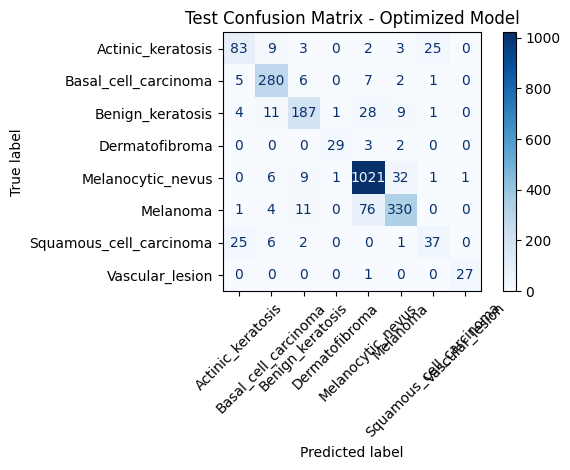

In [37]:
# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Test Confusion Matrix - Optimized Model')
plt.tight_layout()
plt.savefig('optimized_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

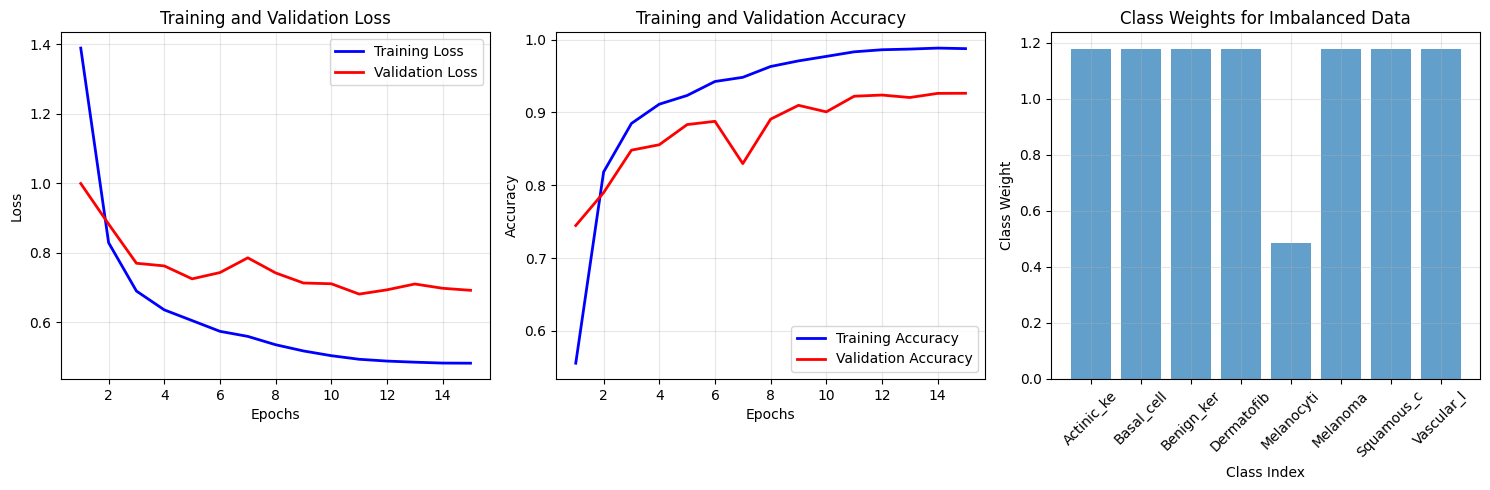

In [38]:
# Learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Training Loss', linewidth=2)
plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, 'b-', label='Training Accuracy', linewidth=2)
plt.plot(range(1, len(val_accs)+1), val_accs, 'r-', label='Validation Accuracy', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.bar(range(len(class_weights)), class_weights, alpha=0.7)
plt.xlabel('Class Index')
plt.ylabel('Class Weight')
plt.title('Class Weights for Imbalanced Data')
plt.xticks(range(len(unique_classes)), [cls[:10] for cls in unique_classes], rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('optimized_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
# Saving the final model
torch.save(model.state_dict(), 'final_optimized_swin_model3.pth')
print("Final optimized model saved!")

Final optimized model saved!


# **Balanced Accuracy**

In [40]:
from sklearn.metrics import balanced_accuracy_score

In [41]:
print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
balanced_acc = balanced_accuracy_score(val_labels, val_preds)
print("\n")
print(f"Balanced Accuracy Rate: {balanced_acc:.4f}")

Val Loss: 0.6918, Val Acc: 0.9263


Balanced Accuracy Rate: 0.9248


# **Feature Extraction**

In [48]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import pickle
from transformers import SwinModel, AutoImageProcessor
import gc

In [49]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [50]:
# Define the class names
unique_classes = ['Actinic_keratosis', 'Basal_cell_carcinoma', 'Benign_keratosis', 
                  'Dermatofibroma', 'Melanocytic_nevus', 'Melanoma', 
                  'Squamous_cell_carcinoma', 'Vascular_lesion']
NUM_CLASSES = len(unique_classes)

In [51]:
# Model name
model_name = "microsoft/swin-large-patch4-window7-224-in22k"

In [52]:
# Define the OptimizedSwinClassifier
class OptimizedSwinClassifier(nn.Module):
    def __init__(self, num_classes=8, dropout_rate=0.3):
        super(OptimizedSwinClassifier, self).__init__()
        self.backbone = SwinModel.from_pretrained(model_name)
        hidden_size = self.backbone.config.hidden_size
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate // 2),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate // 4),
            nn.Linear(hidden_size // 4, num_classes)
        )
    
    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        pooled_output = outputs.last_hidden_state.mean(dim=1)  
        logits = self.classifier(pooled_output)
        return logits
    
    def extract_features(self, pixel_values):
        """Extract the features before the classifier layer (after backbone + pooling)"""
        with torch.no_grad():  # Ensure no gradients are computed
            outputs = self.backbone(pixel_values=pixel_values)
            pooled_output = outputs.last_hidden_state.mean(dim=1) 
            return pooled_output.detach().cpu().numpy()

# Initializing the model
print("Loading the trained model...")
model = OptimizedSwinClassifier(num_classes=NUM_CLASSES)

Using device: cuda
Loading the trained model...


In [53]:
# Loading the trained weights
try:
    model.load_state_dict(torch.load('best_optimized_swin_model2.pth', map_location=device))
    print("Loaded model from 'best_optimized_swin_model2.pth'")
except FileNotFoundError:
    try:
        model.load_state_dict(torch.load('final_optimized_swin_model3.pth', map_location=device))
        print("Loaded model from 'final_optimized_swin_model3.pth'")
    except FileNotFoundError:
        print("Error: Could not find the trained model file. Please check the file path.")
        raise

model.to(device)
model.eval()  # Set to evaluation mode
print("Model loaded successfully!")

Loaded model from 'best_optimized_swin_model2.pth'
Model loaded successfully!


In [54]:
# Defining a dataset for feature extraction that returns the image paths
class FeatureExtractionDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        
        try:
            # Load the image
            img = Image.open(img_path).convert('RGB')
            # Apply transformations
            img_tensor = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img_tensor = torch.zeros(3, 224, 224)
        
        return {
            'pixel_values': img_tensor,
            'image_path': img_path
        }

In [55]:
# Function to extract the features
def extract_features(dataframe, batch_size=32):
    dataset = FeatureExtractionDataset(dataframe)
    try:
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
    except RuntimeError:
        print("Using fewer workers due to runtime constraints...")
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
    
    all_features = []
    all_image_paths = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            pixel_values = batch['pixel_values'].to(device, non_blocking=True)
            image_paths = batch['image_path']
            
            # Extract features
            features = model.extract_features(pixel_values)
            
            all_features.append(features)
            all_image_paths.extend(image_paths)
            
            # Clearing the GPU memory periodically
            if len(all_features) % 10 == 0:
                torch.cuda.empty_cache()
    
    # Concatenating all the features
    all_features = np.concatenate(all_features, axis=0)
    
    # Creating a dictionary mapping the image paths to the features
    features_dict = {img_path: feat for img_path, feat in zip(all_image_paths, all_features)}
    
    return features_dict

In [56]:
# Function to join the features with dataframes
def join_features_with_df(df, features_dict, dataset_name):
    print(f"Joining features with {dataset_name} dataframe...")
    
    # Creating a new dataframe to store the features
    feature_dim = next(iter(features_dict.values())).shape[0]
    feature_cols = [f"feature_{i}" for i in range(feature_dim)]
    
    # Initializing an array to store the features in the same order as the dataframe
    features_array = np.zeros((len(df), feature_dim))
    missing_count = 0
    
    # Filling the features array
    for i, img_path in enumerate(df['image_path']):
        if img_path in features_dict:
            features_array[i] = features_dict[img_path]
        else:
            print(f"Warning: No features found for image {img_path}")
            missing_count += 1
    
    if missing_count > 0:
        print(f"Warning: {missing_count} images had missing features in {dataset_name}")
    
    # Creating a dataframe with the features
    features_df = pd.DataFrame(features_array, columns=feature_cols)
    
    # Joining with the original dataframe
    joined_df = pd.concat([df.reset_index(drop=True), features_df], axis=1)
    
    return joined_df

In [58]:
print("="*50)
print("STARTING FEATURE EXTRACTION PROCESS")
print("="*50)

# Extracting the features for the training dataset
print("\n1. Processing Training Dataset...")
train_features_dict = extract_features(train_df, batch_size=32)
print(f"Extracted features for {len(train_features_dict)} training images")

STARTING FEATURE EXTRACTION PROCESS

1. Processing Training Dataset...


Extracting features: 100%|██████████| 922/922 [06:29<00:00,  2.37it/s]

Extracted features for 29488 training images


In [59]:
# Clearing the memory
torch.cuda.empty_cache()
gc.collect()
# Extracting the features for the test dataset
print("\n2. Processing Test Dataset...")
test_features_dict = extract_features(test_df, batch_size=32)
print(f"Extracted features for {len(test_features_dict)} test images")

# Clearing the memory
torch.cuda.empty_cache()
gc.collect()


2. Processing Test Dataset...


Extracting features: 100%|██████████| 72/72 [00:31<00:00,  2.28it/s]


Extracted features for 2293 test images


0

In [60]:
# Extracting the features for the validation dataset
print("\n3. Processing Validation Dataset...")
val_features_dict = extract_features(valid_df, batch_size=32)
print(f"Extracted features for {len(val_features_dict)} validation images")

# Clear memory
torch.cuda.empty_cache()
gc.collect()


3. Processing Validation Dataset...


Extracting features: 100%|██████████| 231/231 [01:38<00:00,  2.35it/s]


Extracted features for 7372 validation images


0

In [61]:
# Joining the features with the dataframes
print("\n" + "="*50)
print("JOINING FEATURES WITH DATAFRAMES")
print("="*50)

joined_train_df = join_features_with_df(train_df, train_features_dict, "training")
joined_val_df = join_features_with_df(valid_df, val_features_dict, "validation")
joined_test_df = join_features_with_df(test_df, test_features_dict, "test")


JOINING FEATURES WITH DATAFRAMES
Joining features with training dataframe...
Joining features with validation dataframe...
Joining features with test dataframe...


In [62]:
# Printing the information about the joined dataframes
print(f"\nJoined Training DataFrame shape: {joined_train_df.shape}")
print(f"Joined Validation DataFrame shape: {joined_val_df.shape}")
print(f"Joined Test DataFrame shape: {joined_test_df.shape}")


Joined Training DataFrame shape: (29488, 1563)
Joined Validation DataFrame shape: (7372, 1563)
Joined Test DataFrame shape: (2293, 1563)


In [63]:
# Saving the dataframes
print("\n" + "="*50)
print("SAVING JOINED DATAFRAMES")
print("="*50)

print("Saving joined training dataframe...")
joined_train_df.to_csv("/kaggle/working/joined_train_df_optimized.csv", index=False)
print("Saved: /kaggle/working/joined_train_df_optimized.csv")

print("Saving joined validation dataframe...")
joined_val_df.to_csv("/kaggle/working/joined_val_df_optimized.csv", index=False)
print("Saved: /kaggle/working/joined_val_df_optimized.csv")

print("Saving joined test dataframe...")
joined_test_df.to_csv("/kaggle/working/joined_test_df_optimized.csv", index=False)
print("Saved: /kaggle/working/joined_test_df_optimized.csv")


SAVING JOINED DATAFRAMES
Saving joined training dataframe...
Saved: /kaggle/working/joined_train_df_optimized.csv
Saving joined validation dataframe...
Saved: /kaggle/working/joined_val_df_optimized.csv
Saving joined test dataframe...
Saved: /kaggle/working/joined_test_df_optimized.csv
